In [1]:
import numpy as np
import pandas as pd
import sklearn
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#library for oversampling dataset
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, SMOTENC, ADASYN
#plot
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
#feature selection
import sklearn.feature_selection

#model selection
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import xgboost as xgb

#Part1

**Helper Function**

In [2]:
def calculate_metrics(model, X_test_scaled, Y_test):
    # Get model predictions
    y_predict_r = model.predict(X_test_scaled)
    
    # Calculate evaluation metrics for assesing performance of the model.
    roc=roc_auc_score(Y_test, y_predict_r)
    acc = accuracy_score(Y_test, y_predict_r)
    prec = precision_score(Y_test, y_predict_r)
    rec = recall_score(Y_test, y_predict_r)
    f1 = f1_score(Y_test, y_predict_r)
    
    return acc, roc, prec, rec, f1

def train_and_get_metrics(model, X_train, Y_train, X_test, Y_test):

    # All features of dataset are float values. You normalize all features of the train and test dataset here.
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Call the fit model function to train the model on the normalized features and the diagnosis values
    model = model.fit(X_train_scaled, Y_train)

    # Make predictions on test dataset and calculate metrics.
    roc, acc, prec, rec, f1 = calculate_metrics(model, X_test_scaled, Y_test)

    display_df = pd.DataFrame([[acc, roc, prec, rec, f1, X_test_scaled.shape[1]]], columns=["Accuracy", "ROC", "Precision", "Recall", "F1 Score", 'Feature Count'])
    
    return display_df

def multi_model_train_and_test(model, X_train, Y_train, X_test, Y_test):
    model.fit(X_train, Y_train)
    predictions = model.predict_proba(X_test)
    pred_label = model.predict(X_test) 

    # Calculate evaluation metrics for assesing performance of the model.
    roc=roc_auc_score(Y_test, predictions[:,1])
    acc = accuracy_score(Y_test, pred_label)
    prec = precision_score(Y_test, pred_label)
    rec = recall_score(Y_test, pred_label)
    f1 = f1_score(Y_test, pred_label)
    
    display_df = pd.DataFrame([[acc, roc, prec, rec, f1, X_train.shape[1]]], columns=["Accuracy", "ROC", "Precision", "Recall", "F1 Score", 'Feature Count'])
    return display_df

**Mounted Drive**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Get Data**

In [4]:
data_path = "/content/drive/MyDrive/missingData/imbalance data/dataImbalance.csv"
df = pd.read_csv(data_path)

In [40]:
df.head(10)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,1,42,2,0.00,1,1,1,101348.88,1
1,608,2,1,41,1,83807.86,1,0,1,112542.58,0
2,502,0,1,42,8,159660.80,3,1,0,113931.57,1
3,699,0,1,39,1,0.00,2,0,0,93826.63,0
4,850,2,1,43,2,125510.82,1,1,1,79084.10,0
5,645,2,0,44,8,113755.78,2,1,0,149756.71,1
6,822,0,0,50,7,0.00,2,1,1,10062.80,0
7,376,1,1,29,4,115046.74,4,1,0,119346.88,1
8,501,0,0,44,4,142051.07,2,0,1,74940.50,0
9,684,0,0,27,2,134603.88,1,1,1,71725.73,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


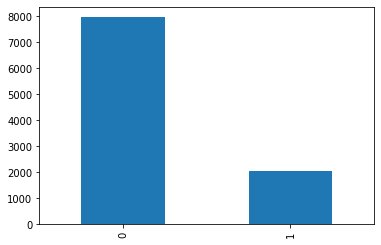

In [6]:
df['Exited'].value_counts().plot(kind='bar')

**Preprocessing Data**

In [7]:
#drop collumns not affect such as: name, id, position
df = df.drop(columns = ['RowNumber','CustomerId','Surname'])
#convert categorical value => number value
#Gender
Gender_dict = {ele:i for i,ele in enumerate(df["Gender"].value_counts().keys())}
df["Gender"] = df["Gender"].map(Gender_dict)
#Geography
Geography_dict = {ele:i for i,ele in enumerate(df["Geography"].value_counts().keys())}
df["Geography"] = df["Geography"].map(Geography_dict)

**Split dataset -> train/dev/val/test**

In [8]:
df['Exited'].value_counts()
#7:1:1:1
features = list(set(df.columns).difference({"Exited"}))
target = ["Exited"]
y = df[target]

In [9]:
#split id
id_pos = np.where(y.values.reshape(-1) == 1)[0]
id_neg = np.where(y.values.reshape(-1) == 0)[0]

#shuffle id
np.random.shuffle(id_pos)
np.random.shuffle(id_neg)

#train
id_train_neg = id_neg[:int(len(id_neg) * 0.8)]
id_train_pos = id_pos[:int(len(id_pos) * 0.8)]
id_train = np.concatenate((id_train_neg, id_train_pos), axis = 0)

#dev
id_dev_neg = id_neg[int(len(id_neg) * 0.8):int(len(id_neg) * 0.85)]
id_dev_pos = id_pos[int(len(id_pos) * 0.8):int(len(id_pos) * 0.85)]
id_dev = np.concatenate((id_dev_neg, id_dev_pos), axis = 0)

#val
id_val_neg = id_neg[int(len(id_neg) * 0.85):int(len(id_neg) * 0.9)]
id_val_pos = id_pos[int(len(id_pos) * 0.85):int(len(id_pos) * 0.9)]
id_val = np.concatenate((id_val_neg, id_val_pos), axis = 0)

#test
id_test_neg = id_neg[int(len(id_neg) * 0.9):]
id_test_pos = id_pos[int(len(id_pos) * 0.9):]
id_test = np.concatenate((id_test_neg, id_test_pos), axis = 0)

# create dataste
data_train = df.iloc[id_train]
data_val = df.iloc[id_val]
data_dev = df.iloc[id_dev]
data_test = df.iloc[id_test] 

In [10]:
print("data_train has shape: ",data_train.shape)
print("data_val has shape: ",data_val.shape)
print("data_dev has shape: ",data_dev.shape)
print("data_test has shape: ",data_test.shape)

data_train has shape:  (7999, 11)
data_val has shape:  (500, 11)
data_dev has shape:  (500, 11)
data_test has shape:  (1001, 11)


**Create baseline model based on dev-test**

In [11]:
model1 = RandomForestClassifier(n_estimators=100,
                                max_depth=5,
                                min_samples_split=200,
                                class_weight=None,
                                max_features=10)

model2 = RandomForestClassifier(n_estimators=500, 
                                max_depth=10, 
                                min_samples_split=400, 
                                random_state=12, 
                                class_weight="balanced",
                                max_features="auto")

model3 = RandomForestClassifier(n_estimators=800, 
                                max_depth=10, 
                                min_samples_split=200, 
                                random_state=12, 
                                class_weight="balanced",
                                max_features="sqrt")

In [12]:
Random_forest1 = train_and_get_metrics(model1,data_train[features], data_train[target],data_dev[features], data_dev[target])
Random_forest2 = train_and_get_metrics(model2,data_train[features], data_train[target],data_dev[features], data_dev[target])
Random_forest3 = train_and_get_metrics(model3,data_train[features], data_train[target],data_dev[features], data_dev[target])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [13]:
results = pd.DataFrame({})

In [14]:
all_features_eval_df = Random_forest1
all_features_eval_df.index = ['RandomForest1']
all_features_eval_df["Description"] = "num_trees: 500, class_weight: balance, max_features: auto, max_depth: 5"

results = all_features_eval_df
results.head()

,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count,Description
RandomForest1,0.718962,0.866,0.786885,0.470588,0.588957,10,"num_trees: 500, class_weight: balance, max_fea..."


In [15]:
all_features_eval_df = Random_forest2
all_features_eval_df.index = ['RandomForest2']
all_features_eval_df["Description"] = "num_trees: 500, class_weight: balance, max_features: auto, max_depth: 10"

results = results.append(all_features_eval_df)
results.head()

,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count,Description
RandomForest1,0.718962,0.866,0.786885,0.470588,0.588957,10,"num_trees: 500, class_weight: balance, max_fea..."
RandomForest2,0.775939,0.800,0.506757,0.735294,0.600000,10,"num_trees: 500, class_weight: balance, max_fea..."


In [16]:
all_features_eval_df = Random_forest3
all_features_eval_df.index = ['RandomForest3']
all_features_eval_df["Description"] = "num_trees: 800, class_weight: balance, max_features: sqrt, max_depth: 10"

results = results.append(all_features_eval_df)
results.head()

,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count,Description
RandomForest1,0.718962,0.866,0.786885,0.470588,0.588957,10,"num_trees: 500, class_weight: balance, max_fea..."
RandomForest2,0.775939,0.800,0.506757,0.735294,0.600000,10,"num_trees: 500, class_weight: balance, max_fea..."
RandomForest3,0.790891,0.818,0.539007,0.745098,0.625514,10,"num_trees: 800, class_weight: balance, max_fea..."


In [17]:
print("Choose randomForest3 is baseline model")

model_baseline = RandomForestClassifier(n_estimators=800, 
                                        max_depth=10, 
                                        min_samples_split=200, 
                                        random_state=12, 
                                        class_weight="balanced",
                                        max_features="sqrt")

Choose randomForest3 is baseline model


**Undersampling method**


*   70:30
*   60:40
*   50:50

Note: Less data may cause overfiting



In [18]:
print(len(id_train_pos)/7999 * 100)
print(len(id_train_neg)/7999 * 100)

20.365045630703836
79.63495436929617


**get pos/neg == 30/70**

In [19]:
# len(pos) == 1629:
# to find len(neg) = x:
# to get ratio 30/70: => 1629/(x + 1629) = 0.3 => x = 3801
np.random.shuffle(id_train_neg)
id_train_neg_30_70 = id_train_neg[:3801]
id_train_30_70 = np.concatenate((id_train_neg_30_70, id_train_pos), axis = 0)

**get pos/neg == 40/60**

In [20]:
# len(pos) == 1629:
# to find len(neg) = x:
# to get ratio 40/60: => 1629/(x + 1629) = 0.4 => x = 2444
np.random.shuffle(id_train_neg)
id_train_neg_40_60 = id_train_neg[:2444]
id_train_40_60 = np.concatenate((id_train_neg_40_60, id_train_pos), axis = 0)

**get pos/neg == 50/50**

In [21]:
# len(pos) == 1629:
# to find len(neg) = x:
# to get ratio 50/50: => x = 1629
np.random.shuffle(id_train_neg)
id_train_neg_50_50 = id_train_neg[:1629]
id_train_50_50 = np.concatenate((id_train_neg_50_50, id_train_pos), axis = 0)

In [22]:
data_train_30_70 = df.iloc[id_train_30_70]
data_train_40_60 = df.iloc[id_train_40_60]
data_train_50_50 = df.iloc[id_train_50_50]

In [23]:
under_sampling_30_70 = train_and_get_metrics(model_baseline,data_train_30_70[features], data_train_30_70[target],data_test[features], data_test[target])
under_sampling_40_60 = train_and_get_metrics(model_baseline,data_train_40_60[features], data_train_40_60[target],data_test[features], data_test[target])
under_sampling_50_50 = train_and_get_metrics(model_baseline,data_train_50_50[features], data_train_50_50[target],data_test[features], data_test[target])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [24]:
all_features_eval_df = under_sampling_30_70
all_features_eval_df.index = ['under_sampling_30_70']
all_features_eval_df["Description"] = ""

results = results.append(all_features_eval_df)
results.head(10)

,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count,Description
RandomForest1,0.718962,0.866000,0.786885,0.470588,0.588957,10,"num_trees: 500, class_weight: balance, max_fea..."
RandomForest2,0.775939,0.800000,0.506757,0.735294,0.600000,10,"num_trees: 500, class_weight: balance, max_fea..."
RandomForest3,0.790891,0.818000,0.539007,0.745098,0.625514,10,"num_trees: 800, class_weight: balance, max_fea..."
under_sampling_30_70,0.760370,0.775225,0.467290,0.735294,0.571429,10,


In [25]:
all_features_eval_df = under_sampling_40_60
all_features_eval_df.index = ['under_sampling_40_60']
all_features_eval_df["Description"] = ""

results = results.append(all_features_eval_df)
results.head(10)

,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count,Description
RandomForest1,0.718962,0.866000,0.786885,0.470588,0.588957,10,"num_trees: 500, class_weight: balance, max_fea..."
RandomForest2,0.775939,0.800000,0.506757,0.735294,0.600000,10,"num_trees: 500, class_weight: balance, max_fea..."
RandomForest3,0.790891,0.818000,0.539007,0.745098,0.625514,10,"num_trees: 800, class_weight: balance, max_fea..."
under_sampling_30_70,0.760370,0.775225,0.467290,0.735294,0.571429,10,
under_sampling_40_60,0.760370,0.775225,0.467290,0.735294,0.571429,10,


In [26]:
all_features_eval_df = under_sampling_50_50
all_features_eval_df.index = ['under_sampling_50_50']
all_features_eval_df["Description"] = ""

results = results.append(all_features_eval_df)
results.head(10)

,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count,Description
RandomForest1,0.718962,0.866000,0.786885,0.470588,0.588957,10,"num_trees: 500, class_weight: balance, max_fea..."
RandomForest2,0.775939,0.800000,0.506757,0.735294,0.600000,10,"num_trees: 500, class_weight: balance, max_fea..."
RandomForest3,0.790891,0.818000,0.539007,0.745098,0.625514,10,"num_trees: 800, class_weight: balance, max_fea..."
under_sampling_30_70,0.760370,0.775225,0.467290,0.735294,0.571429,10,
under_sampling_40_60,0.760370,0.775225,0.467290,0.735294,0.571429,10,
under_sampling_50_50,0.761449,0.768232,0.458084,0.750000,0.568773,10,


#Part2

**Oversampling**

In [27]:
#Naive random over-sampling
naive_random_oversampling = make_pipeline(RandomOverSampler(sampling_strategy=1, random_state=0), model_baseline)
NAIVE_RANDOM_O = train_and_get_metrics(naive_random_oversampling,data_train[features], data_train[target],data_test[features], data_test[target])

/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


In [28]:
all_features_eval_df = NAIVE_RANDOM_O 
all_features_eval_df.index = ['naive_random_oversampling']
all_features_eval_df["Description"] = ""

results = results.append(all_features_eval_df)
results.tail()

,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count,Description
RandomForest3,0.790891,0.818000,0.539007,0.745098,0.625514,10,"num_trees: 800, class_weight: balance, max_fea..."
under_sampling_30_70,0.760370,0.775225,0.467290,0.735294,0.571429,10,
under_sampling_40_60,0.760370,0.775225,0.467290,0.735294,0.571429,10,
under_sampling_50_50,0.761449,0.768232,0.458084,0.750000,0.568773,10,
naive_random_oversampling,0.785172,0.800200,0.506536,0.759804,0.607843,10,


**Smote**

In [29]:
smotes = {0 : 'SMOTE',
          1 : 'BorderlineSMOTE',
          2 : 'SVMSMOTE',
          3 : 'ADASYN'}

methods = [
    SMOTE(sampling_strategy = 1, random_state=0),
    BorderlineSMOTE(sampling_strategy = 1, random_state=0, kind='borderline-1'),
    SVMSMOTE(sampling_strategy = 1, random_state=0),
    ADASYN(sampling_strategy = 1, random_state=0)
]

for i,method in enumerate(methods):
    smote_random_oversampling_model = make_pipeline(method, model_baseline)
    SMOTE_RO = train_and_get_metrics(smote_random_oversampling_model,data_train[features], data_train[target],data_test[features], data_test[target])
    all_features_eval_df = SMOTE_RO
    all_features_eval_df.index = [smotes[i]]
    all_features_eval_df["Description"] = ""

    results = results.append(all_features_eval_df)

results.tail()

/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count,Description
naive_random_oversampling,0.785172,0.800200,0.506536,0.759804,0.607843,10,
SMOTE,0.797150,0.822178,0.546099,0.754902,0.633745,10,
BorderlineSMOTE,0.783056,0.785215,0.483283,0.779412,0.596623,10,
SVMSMOTE,0.791737,0.825175,0.553506,0.735294,0.631579,10,
ADASYN,0.780780,0.793207,0.495208,0.759804,0.599613,10,


**punish model**

In [30]:
model_pen = RandomForestClassifier(n_estimators=500, 
                                max_depth=10, 
                                min_samples_split=400, 
                                random_state=12, 
                                class_weight={0: 0.1,
                                              1: 0.9},
                                max_features="auto")

penalty_method = train_and_get_metrics(model_pen,data_train[features], data_train[target],data_test[features], data_test[target])
all_features_eval_df = penalty_method
all_features_eval_df.index = ["penalty_method1"]
all_features_eval_df["Description"] = "0: 0.1, 1: 0.9"
results = results.append(all_features_eval_df)

results.tail()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count,Description
SMOTE,0.797150,0.822178,0.546099,0.754902,0.633745,10,
BorderlineSMOTE,0.783056,0.785215,0.483283,0.779412,0.596623,10,
SVMSMOTE,0.791737,0.825175,0.553506,0.735294,0.631579,10,
ADASYN,0.780780,0.793207,0.495208,0.759804,0.599613,10,
penalty_method1,0.695749,0.547453,0.303937,0.946078,0.460072,10,"0: 0.1, 1: 0.9"


In [31]:
model_pen2 = RandomForestClassifier(n_estimators=500, 
                                max_depth=10, 
                                min_samples_split=400, 
                                random_state=12, 
                                class_weight={0: 0.3,
                                              1: 0.7},
                                max_features="auto")

penalty_method = train_and_get_metrics(model_pen2,data_train[features], data_train[target],data_test[features], data_test[target])
all_features_eval_df = penalty_method
all_features_eval_df.index = ["penalty_method2"]
all_features_eval_df["Description"] = "0: 0.3, 1: 0.7"
results = results.append(all_features_eval_df)

results.tail()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count,Description
BorderlineSMOTE,0.783056,0.785215,0.483283,0.779412,0.596623,10,
SVMSMOTE,0.791737,0.825175,0.553506,0.735294,0.631579,10,
ADASYN,0.780780,0.793207,0.495208,0.759804,0.599613,10,
penalty_method1,0.695749,0.547453,0.303937,0.946078,0.460072,10,"0: 0.1, 1: 0.9"
penalty_method2,0.748379,0.846154,0.632979,0.583333,0.607143,10,"0: 0.3, 1: 0.7"


**use multi model**

**svm**

**All feature**

In [32]:
svm_classifier = LinearSVC(penalty='l2', 
                           loss='squared_hinge',
                           tol=0.0001,
                           C=0.9,
                           dual=False,
                           class_weight='balanced',
                           max_iter=1000
                          )
svm_classifier = CalibratedClassifierCV(svm_classifier) 
svm_method = multi_model_train_and_test(svm_classifier,data_train[features], data_train[target],data_test[features], data_test[target])
all_features_eval_df = svm_method
all_features_eval_df.index = ["svm_method1"]
all_features_eval_df["Description"] = "all features"
results = results.append(all_features_eval_df)
results.tail()

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example u

,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count,Description
SVMSMOTE,0.791737,0.825175,0.553506,0.735294,0.631579,10,
ADASYN,0.780780,0.793207,0.495208,0.759804,0.599613,10,
penalty_method1,0.695749,0.547453,0.303937,0.946078,0.460072,10,"0: 0.1, 1: 0.9"
penalty_method2,0.748379,0.846154,0.632979,0.583333,0.607143,10,"0: 0.3, 1: 0.7"
svm_method1,0.791209,0.699738,0.424242,0.068627,0.118143,10,all features


**Numeric feature**

In [33]:
numeric_col = ['CreditScore','Balance','EstimatedSalary']

In [34]:
svm_classifier = LinearSVC(penalty='l2', 
                           loss='squared_hinge',
                           tol=0.0001,
                           C=0.9,
                           dual=False,
                           class_weight='balanced',
                           max_iter=1000
                          )
svm_classifier = CalibratedClassifierCV(svm_classifier) 
svm_method = multi_model_train_and_test(svm_classifier,data_train[numeric_col], data_train[target],data_test[numeric_col], data_test[target])
all_features_eval_df = svm_method
all_features_eval_df.index = ["svm_method2"]
all_features_eval_df["Description"] = "numeric features"
results = results.append(all_features_eval_df)
results.tail()

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example u

,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count,Description
ADASYN,0.780780,0.793207,0.495208,0.759804,0.599613,10,
penalty_method1,0.695749,0.547453,0.303937,0.946078,0.460072,10,"0: 0.1, 1: 0.9"
penalty_method2,0.748379,0.846154,0.632979,0.583333,0.607143,10,"0: 0.3, 1: 0.7"
svm_method1,0.791209,0.699738,0.424242,0.068627,0.118143,10,all features
svm_method2,0.796204,0.561253,0.000000,0.000000,0.000000,3,numeric features


**knn**

In [35]:
knn_classifier = KNeighborsClassifier(n_neighbors = 10, 
                                      weights = 'distance',
                                      algorithm = 'kd_tree',
                                      metric = 'minkowski'
                                      )

knn_method = train_and_get_metrics(knn_classifier,data_train[features], data_train[target],data_test[features], data_test[target])
all_features_eval_df = knn_method
all_features_eval_df.index = ["knn_method"]
all_features_eval_df["Description"] = "all feature"
results = results.append(all_features_eval_df)
results.tail()

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count,Description
penalty_method1,0.695749,0.547453,0.303937,0.946078,0.460072,10,"0: 0.1, 1: 0.9"
penalty_method2,0.748379,0.846154,0.632979,0.583333,0.607143,10,"0: 0.3, 1: 0.7"
svm_method1,0.791209,0.699738,0.424242,0.068627,0.118143,10,all features
svm_method2,0.796204,0.561253,0.000000,0.000000,0.000000,3,numeric features
knn_method,0.668709,0.844156,0.730769,0.372549,0.493506,10,all feature


**Logistic Regression**

In [36]:
log_reg = LogisticRegression(C = 0.0001)
log_method = multi_model_train_and_test(log_reg,data_train[features], data_train[target],data_test[features], data_test[target])
all_features_eval_df = log_method
all_features_eval_df.index = ["logisitcs_method"]
all_features_eval_df["Description"] = "all feature"
results = results.append(all_features_eval_df)
results.tail()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count,Description
penalty_method2,0.748379,0.846154,0.632979,0.583333,0.607143,10,"0: 0.3, 1: 0.7"
svm_method1,0.791209,0.699738,0.424242,0.068627,0.118143,10,all features
svm_method2,0.796204,0.561253,0.000000,0.000000,0.000000,3,numeric features
knn_method,0.668709,0.844156,0.730769,0.372549,0.493506,10,all feature
logisitcs_method,0.796204,0.556222,0.000000,0.000000,0.000000,10,all feature


In [37]:
log_reg = LogisticRegression(C = 0.0001)
log_method = multi_model_train_and_test(log_reg,data_train[numeric_col], data_train[target],data_test[numeric_col], data_test[target])
all_features_eval_df = log_method
all_features_eval_df.index = ["logisitcs_method"]
all_features_eval_df["Description"] = "numeric feature"
results = results.append(all_features_eval_df)
results.tail()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count,Description
svm_method1,0.791209,0.699738,0.424242,0.068627,0.118143,10,all features
svm_method2,0.796204,0.561253,0.000000,0.000000,0.000000,3,numeric features
knn_method,0.668709,0.844156,0.730769,0.372549,0.493506,10,all feature
logisitcs_method,0.796204,0.556222,0.000000,0.000000,0.000000,10,all feature
logisitcs_method,0.796204,0.556542,0.000000,0.000000,0.000000,3,numeric feature


**Linear Gradient Boosting**

In [38]:
lgb_classifier = lgb.LGBMClassifier(n_estimator = 800, 
                                    objective = 'binary', 
                                    class_weight = 'balanced',
                                    learning_rate = 0.1,
                                    reg_alpha = 0.1,
                                    reg_lambda = 0.1,
                                    subsample = 0.8,
                                    n_job = -1,
                                    random_state = 12
                                   )

lgb_method = train_and_get_metrics(lgb_classifier,data_train[features], data_train[target],data_test[features], data_test[target])
all_features_eval_df = lgb_method
all_features_eval_df.index = ["linear_gradient_boosting_method"]
all_features_eval_df["Description"] = ""
results = results.append(all_features_eval_df)
results.tail()

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count,Description
svm_method2,0.796204,0.561253,0.000000,0.000000,0.000000,3,numeric features
knn_method,0.668709,0.844156,0.730769,0.372549,0.493506,10,all feature
logisitcs_method,0.796204,0.556222,0.000000,0.000000,0.000000,10,all feature
logisitcs_method,0.796204,0.556542,0.000000,0.000000,0.000000,3,numeric feature
linear_gradient_boosting_method,0.786835,0.823177,0.550186,0.725490,0.625793,10,


In [39]:
model_xgb = xgb.XGBClassifier(random_state=42, n_estimators = 800)
xgb_method = train_and_get_metrics(model_xgb,data_train[features], data_train[target],data_test[features], data_test[target])
all_features_eval_df = xgb_method
all_features_eval_df.index = ["xgboost_method"]
all_features_eval_df["Description"] = ""
results = results.append(all_features_eval_df)
results.tail()

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count,Description
knn_method,0.668709,0.844156,0.730769,0.372549,0.493506,10,all feature
logisitcs_method,0.796204,0.556222,0.000000,0.000000,0.000000,10,all feature
logisitcs_method,0.796204,0.556542,0.000000,0.000000,0.000000,3,numeric feature
linear_gradient_boosting_method,0.786835,0.823177,0.550186,0.725490,0.625793,10,
xgboost_method,0.730611,0.870130,0.789062,0.495098,0.608434,10,
